# Tutorial 2b - Predicting heart failure from clinical data

Original author: [Santeri Rytky](https://www.oulu.fi/fi/tutkijat/santeri-rytky) 

In this tutorial, you will use an open-source dataset to predict heart failure from clinical measurements. Learning outcomes:

- Training Machine learning classifiers for a binary target
- Working with tabular data
- Splitting the data to ensure consistent results
- Evaluating results of the binary classifier
- How to interpret model decisions?

The dataset in this tutorial is based on a study by Chicco & Jurman [1], where clinical features from 299 heart failure patients are collected at the Allied Hospital in Faisalabad (Punjab, Pakistan). 

[1] Chicco, D., Jurman, G. Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Med Inform Decis Mak 20, 16 (2020). https://doi.org/10.1186/s12911-020-1023-5

---



# 1. Data loading and preprocessing

The first step in every Python code is to import necessary **libraries**. Libraries contain collections of functions and classes that can be used instead of writing every function from scratch. For example, *numpy* allows making various mathematical operations for arrays, and *scikit-learn* (sklearn) provides an extensive toolbox of machine learning functions.

In Google Colab, it is also necessary to mount the drive folder into Python. This allows us to read files from drive.

In [1]:
'''# Mount the Google drive folder to Colab
from google.colab import drive
drive.mount('/content/drive')

# System-specific parameters and functions
import sys
# Add the tutorial folder to Python path
sys.path.append('/content/drive/My Drive/MLinMedicine/Tutorial1')'''

"# Mount the Google drive folder to Colab\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n# System-specific parameters and functions\nimport sys\n# Add the tutorial folder to Python path\nsys.path.append('/content/drive/My Drive/MLinMedicine/Tutorial1')"

Now we can also import the other libraries. A short description of their function is shown in the commented lines (green). You can hold the `ctrl` key to see details of each library.

In [ ]:
# Run mathematical operations
import numpy as np

# Generate informative plots
import matplotlib.pyplot as plt

# Work on tabular data (tables)
import pandas as pd

# Scikit-learn is a package with multiple machine learning tools

# Preprocessing
from sklearn.preprocessing import StandardScaler
# Data splitting
from sklearn.model_selection import StratifiedKFold, train_test_split
# Random forest classifier
from sklearn.linear_model import LogisticRegression
# Evaluation of results
from sklearn.metrics import confusion_matrix, \
    accuracy_score, f1_score, precision_score, recall_score, \
    average_precision_score, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay, auc

# Feature selection and interpretation
#!pip install shap --quiet
import shap

/Users/hpham/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's now read the data from the Drive folder. With `data.info()`, we can take a look at a basic summary of the data.






In [3]:
# Variables for the tutorial
seed = 1

# Load the heart failure dataset from .csv file
data = pd.read_csv('./heart_failure_clinical_records_dataset.csv')
# Quick description of file contents
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


It seems the data consists of a table of 13 columns, with *DEATH_EVENT* being the target variable. Some of the variables are integers, but there are also measurements including decimal points, such as *serum_creatinine* and *platelets*. Below, is a short description of the variables.

Feature | Description
--- | ---
**Age** | Age of the patient (years)
**Aneamia**|Decrease of red blood cells or hemoglobin (boolean)
**creatinine_phosphokinase**|Level of the CPK enzyme in the blood (mcg/L)
**diabetes**|If the patient has diabetes (boolean)
**ejection_fraction**|Percentage of blood leaving the heart at each contraction
**high_blood_pressure**|If the patient has hypertension (boolean)
**platelets**|Platelets in the blood (kiloplatelets/mL)
**serum_creatinine**|Level of serum creatinine in the blood (mg/dL)
**serum_sodium**|Level of serum sodium in the blood (mEq/L)
**sex**|Male or female (binary, female=0, male=1)
**smoking**|If the patient smokes or not (boolean)
**time**|Follow-up period (days)
**DEATH_EVENT**|If the patient deceased during the follow-up period (boolean)


In [4]:
# Simple statistics of each variable
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [5]:
# How many patients died due to a heart failure?
positives = np.sum(data['DEATH_EVENT'])
negatives = len(data['DEATH_EVENT']) - positives
print(f'Dataset consists of {positives} positive and {negatives} negative cases.')

Dataset consists of 96 positive and 203 negative cases.


# 2. Splitting

Now that we had a short glance at the dataset, we could start hypothesizing which **features** are important. Are there any input features that are not clinically relevant or meaningful?

We should split the data into **train and test sets**. The test set should be used only at the end of the study, when all parameters and methods are fixed. This means that we should not change the machine learning pipeline after seeing the final results on the test data.

With the **fixed random seed**, we can get a random sample from the data, but we can ensure that the same result can be obtained again.

In [6]:
# Random seed to ensure reproducibility
seed = 42
# Split the train and test data for both 11 and 2 features
x = data.drop(columns=['DEATH_EVENT'])
y = data['DEATH_EVENT'].values
data_train, data_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=seed, shuffle=True)

# 3. Feature scaling

Next, we create two datasets: One with the first 11 features, and a second one with only two features. The features are all **scaled by subtracting the mean and dividing by the standard deviation**. This is often an important step before training the machine learning model.

Note that this time we scale the train and test data with their own mean and std instead of the values for full dataset.

Another important note is that we only scale input variables, not the output. The target variable is if the patient died of heart failure, and should contain only 0's and 1's.

In [45]:
# Select features
features = ['ejection_fraction', 'serum_creatinine']

# Scale the dataset by mean and standard deviation
scaler = StandardScaler()
scaler_2f = StandardScaler()

# 1st dataset with 11 features
X_train = scaler.fit_transform(data_train.iloc[:, :11])
X_test = scaler.transform(data_test.iloc[:, :11])

# 2nd dataset with 2 features
X2_train = scaler_2f.fit_transform(data_train[features])
X2_test = scaler_2f.transform(data_test[features])

# 4. Model training

To train the machine learning model, we can write a function that conducts the model training (**training loop**). Inside the function, we will conduct **cross-validation**, splitting the data into multiple training and validation **folds**. The cross-validation scheme is illustrated below (blue denotes validation data, source: [Scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html)).

As we saw in the first section, the dataset includes more negative (survived) than positive (heart failure) cases. It is beneficial to **stratify** the data, preserving the distribution of positives and negatives in the training and validation folds. This can be achieved by the **StratifiedKFold** class.

As the predictor, we will use a **Random forest classifier**. It consists of multiple decision trees that finally combine into one binary prediction. The classifier is often trained on subsamples of the training data that are drawn with replacement, this is known as **bootstrapping**. By default, bootstrapping is enabled.

[![Stratified K-Fold Cross Validation](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)](https://scikit-learn.org/stable/modules/cross_validation.html)

In [9]:
# Training loop
from sklearn.ensemble import RandomForestClassifier


def train_skfold(feature, target, metric=accuracy_score, splits=5, threshold=0.5, seed=42):
    """
    Train a classifier with stratified K-fold cross-validation.

    :param feature: Input for the model
    :param target: Ground truth for the model
    :param metric: Metric to compare the predictions and ground truth
    :param splits: Number of cross-validation splits
    :param threshold: Threshold for binary prediction
    :return: Concatenated model predictions, ground truth and metrics for all folds
    """

    # Initialize SKFold-split, shuffle the data prior to splitting
    skfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)

    # Initialize lists
    losses, predictions, targets, models = [], [], [], []

    for train_idx, test_idx in skfold.split(feature, target):
      features_train = feature[train_idx]
      features_val = feature[test_idx]
      target_train = target[train_idx]
      target_val = target[test_idx]

      # Use Classifier with default features as the model
      model = LogisticRegression(max_iter=1000, random_state=seed)

      # Fit on training data
      model.fit(features_train, target_train)

      # Predict on validation split (probability of positive class 1)
      prediction = model.predict_proba(features_val)[:, 1]

      # Estimate performance
      loss = metric(prediction > threshold, target_val)

      # Appending to lists
      losses.append(loss)
      predictions.extend(prediction)
      targets.extend(target_val)
      models.append(model)

    # Convert results to array
    predictions = np.array(predictions)
    targets = np.array(targets)

    return predictions, targets, losses, models

Now that the training loop is defined, we can simply call it using the training data, and other training parameters.

In [10]:
# Train Random Forest classifier on stratified k-fold
predictions, targets, accuracies, models = train_skfold(X_train, Y_train, metric=accuracy_score, splits=5, seed=seed)

# Result on validation data
print('Random Forest accuracy for each cross-validation fold: ', accuracies)
accuracy_avg = np.mean(accuracies) * 100
print(f'\nAverage accuracy across the folds: {accuracy_avg:.1f}%')

Random Forest accuracy for each cross-validation fold:  [0.85, 0.725, 0.875, 0.7, 0.75]

Average accuracy across the folds: 78.0%


# 5. Analysis of results

The trained model yielded average **validation accuracy** of 82.5%. Note that since we split the data five times, we essentially trained five separate models. Some models had higher performance than average: that could imply that the model learned a better parameter set for the decision trees, or that there are "easier" samples to classify (such as abnormally high blood pressure). 

Next we can analyze the results more carefully on the test set. **Note that in real experiments, the test set should be evaluated only when all model parameters and design choices are fixed!** Otherwise there is a risk for overestimating the results. Machine learning researchers have often reported high performance scores on the study data, only to find out that the method does not work in practice due to **overfitting**.

We also used accuracy as the performance metric. It is a very popular metric, but should be avoided when the dataset is **biased** (classes are not equally represented). Since accuracy is simply the ratio of correct predictions, a smaller class could be neglected in the analysis.

To analyze the predictions more carefully, we can plot a confusion matrix (explained below).

![](https://images.prismic.io/encord/edfa849b-03fb-43d2-aba5-1f53a8884e6f_image5.png)

In [12]:
# Calculate confusion matrix on validation data
conf = confusion_matrix(targets, predictions > 0.5)
# Display the results in a table, correct predictions lie on the diagonal
print(pd.DataFrame(conf, index=['True negative', 'True positive'],
             columns=['Predicted negative', 'Predicted positive']))

               Predicted negative  Predicted positive
True negative                 133                  13
True positive                  31                  23


Based on the confusion matrix, we can see that despite high accuracy, half of the positive cases are misclassified.

In [13]:
# Predict the test data as an average of all CV folds

# Prediction for the test set
predictions_test = []
for model in models:
    prediction = model.predict_proba(X_test)[:, 1]
    predictions_test.append(prediction)
# Average the predictions and binarize the output 
predictions_test = np.mean(predictions_test, axis=0)

# Probability threshold
th = 0.5

# Calculate confusion matrix on test data
conf = confusion_matrix(Y_test, predictions_test > th)
# Display the results in a table, correct predictions lie on the diagonal
print(pd.DataFrame(conf, index=['True negative', 'True positive'],
             columns=['Predicted negative', 'Predicted positive']))

# Results on the test set
scores_cv = [
    accuracy_score(Y_test, predictions_test > th),
    f1_score(Y_test, predictions_test > th),
    precision_score(Y_test, predictions_test > th),
    recall_score(Y_test, predictions_test > th),
]

print('\nLogistic regression accuracy: ', scores_cv[0])
print('Logistic regression f1-score', scores_cv[1])
print('Logistic regression precision', scores_cv[2])
print('Logistic regression recall', scores_cv[3])

               Predicted negative  Predicted positive
True negative                  55                   2
True positive                  29                  13

Logistic regression accuracy:  0.6868686868686869
Logistic regression f1-score 0.45614035087719296
Logistic regression precision 0.8666666666666667
Logistic regression recall 0.30952380952380953


On the test data, only 1/3 of the positive cases are classified correct.

We achieved a high precision, but low recall. This means that the patients that are predicted as positive are very likely to die from a heart failure. On the other hand, low recall means that many patients that are going to die are predicted as negative (healthy).

Note that in the previous metrics, we had to **binarize the model output** (in this case, with a 0.5 **threshold**. To analyze the predictions more carefully, we can make plots that include the full range of thresholds from 0 to 1.

# 6. ROC and PR curve analysis

To analyze the model properties more carefully, we can plot **Receiver operating characteristic (ROC) curve and precision-recall curve (PRC)**. The curves are created by changing the **prediction threshold**, and plotting the given metrics on x- and y-axes. 

With ROC curves, **true positive rate** and false positive rate are plotted**. In the case of PRC curve, precision and recall are plotted in a similar way. Since the precision and recall account better for class imbalance, it should be always plotted with ROC curve for biased data (for more details, see [Saito & Rehmsmeier](https://doi.org/10.1371/journal.pone.0118432)).

In both cases, a random guess is plotted by a dotted line, whereas perfect predictions would result in the plot in red.


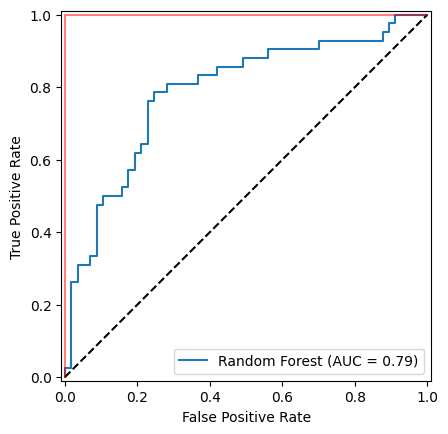

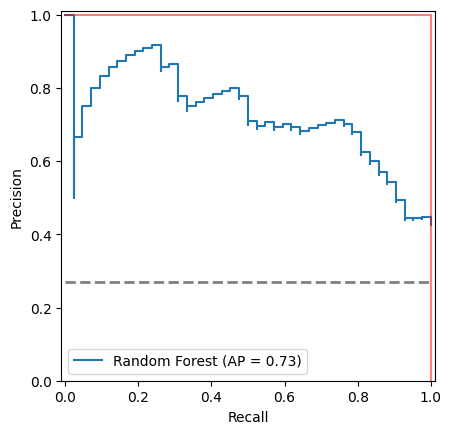

Baseline precision is 27.0%


In [14]:
# ROC Curve
fpr, tpr, thr = roc_curve(Y_test, predictions_test)
# Show the area under curve
auc_score = auc(fpr, tpr)
# Display
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score, name='Random Forest').plot()
# Add baseline (dashed line)
plt.plot([0, 1], [0, 1], '--', color='black')
# Add optimum line (red)
plt.plot([0, 0, 1], [0, 1, 1], '-', alpha=0.5, color='red')
plt.show()

# PRC curve

# Calculate baseline for random guess using the class distribution
positives = np.sum(Y_train)
negatives = len(Y_train) - positives
baseline = positives / (positives + negatives)

# Calculate PR curve and average precision
prec, rec, _ = precision_recall_curve(Y_test, predictions_test)
ap = average_precision_score(Y_test, predictions_test)
# Display PRC and baseline
pr_plot = PrecisionRecallDisplay(precision=prec, recall=rec, average_precision=ap, name='Random Forest').plot()
plt.plot([0, 1], [baseline, baseline], '--', 
         color='black', alpha=0.5, linewidth=2)
# Add optimum line (red)
plt.plot([0, 1, 1], [1, 1, 0], '-', alpha=0.5, color='red')
plt.ylim([0, 1.01])
plt.show()
print(f'Baseline precision is {baseline*100}%')

# 7. Feature importance

The current Random forest classifier was trained on 11 different parameters (**features**). To understand the model's decisions it would be beneficial to know which features are the most important.

SHAP (SHapley Additive exPlanations) uses a game theoretic approach to estimate parameter importance. Lloyd Shapley won the Nobel Prize in Economics by for discovering the Shapley values. In machine learning, the theory can be used to calculate which features contribute most to a specific prediction.

In [15]:
# Result on validation data
print('Accuracy for each cross-validation fold: ', accuracies)

Accuracy for each cross-validation fold:  [0.85, 0.725, 0.875, 0.7, 0.75]


The model from CV-fold 2 seemed to provide the best accuracy of the 5 folds (0.875). Let's see which features are important for the particular model's predicitons.

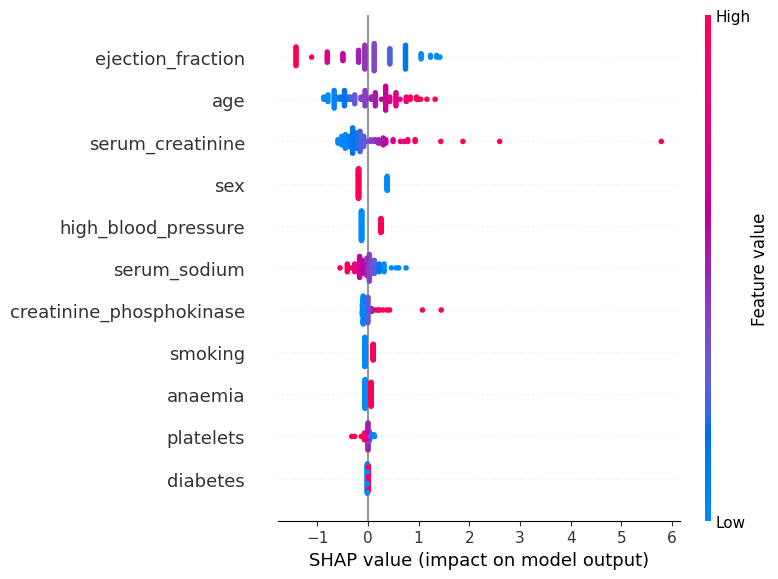

In [16]:
# Interpret the model's predictions with SHAP: SHapley Additive exPlanations
cv_fold = 2
explainer = shap.Explainer(models[cv_fold], X_test)
shap_values = explainer(X_test)

# Visualize the explanations for class 1 (patient death)
# shap.initjs()  # Initialize Javascript
shap.summary_plot(shap_values, X_test, feature_names=data.columns[:11])

From the summary plot, red color represents high value for the specific feature, whereas a dot on the right side has a higher probability to be predicted as positive. The features are sorted based on their relative importance.

We can note here that a result for high serum_creatinine (red) yields a high risk for death (based on this model's prediction). Same is true for low ejection_fraction (blue).

Next, let's look at an individual patient.

In [17]:
patient_ID = 70

shap.initjs()
print('Predicted death: ', models[cv_fold].predict(X_test[patient_ID].reshape(1, -1)), ', true label: ', Y_test[patient_ID])

# Force plot for individual patient
shap.force_plot(
    shap_values.base_values[patient_ID],
    shap_values.values[patient_ID],
    shap_values.data[patient_ID],
    data.columns[:11]
)

Predicted death:  [1] , true label:  1


This patient was correctly predicted as positive. High serum_creatinine and low ejection fraction were contributing to the prediction (Note that the values 0.2854 and 0.51 are not probabilities but the total of shap values). Note that red color on the force plot refers to features contributing to positive prediction.

Also note that the feature values are inversely scaled to show the original values.



In [18]:
patient_ID = 4
shap.initjs()
print('Predicted death: ', models[cv_fold].predict(X_test[patient_ID].reshape(1, -1)), ', true label: ', Y_test[patient_ID])

# Force plot for individual patient
shap.force_plot(
    shap_values.base_values[patient_ID],
    shap_values.values[patient_ID],
    shap_values.data[patient_ID],
    data.columns[:11]
)

Predicted death:  [0] , true label:  0


Here is an example of a patient that was clearly predicted not dying. Note the low serum_creatinine and high ejection fraction. The shap output is below base value, and the prediction is negative.

Multiple force plots can be rotated and stacked together to look at multiple patients:

In [19]:
# shap.initjs()  # Initialize Javascript
# # Force plot for the full test set
shap.force_plot(
    shap_values.base_values,
    shap_values.values,
    shap_values.data,
    data.columns[:11]
)

The current model uses all 11 viable clinical features. However, the study of Chicco & Jurman suggest that the best features for estimating heart failure are serum creatinine and ejection fraction **(the same conclusion can be drawn from the vertical summary plot above)**. We can finally test if using only these 2 features would yield acceptable results. After all, the method would be easier to use if less measurements/information need to be gathered from the patient. A model with less features has also a lower chance of overfitting.

# Conclusion

Based on the results, we can make some important findings:

- Most important features were `serum_creatinine` and `ejection_fraction`, similar findings were reported by Chicco & Jurman
- Validation results were always better compared to the test results. This shows the effect of **overfitting** when searching for the optimum solution

You also learned how to use **cross-validation** in order to maximize data usage. This allows efficient model training when the amount of training data is limited. Other important topics were **stratification** (preserve class distributions) and **bootstrapping** (subsampling with replacement).

Since the machine learning models are often treated as a black box, it is important to learn techniques that increase the model **interpretability**. The SHAP analysis is a great example for visualizing **feature importance**. To read more about SHAP analysis, you can check out the [SHAP Python package](https://github.com/slundberg/shap), and the article by [Lundberg et al.](https://www.nature.com/articles/s41551-018-0304-0.epdf?author_access_token=vSPt7ryUfdSCv4qcyeEuCdRgN0jAjWel9jnR3ZoTv0PdqacSN9qNY_fC0jWkIQUd0L2zaj3bbIQEdrTqCczGWv2brU5rTJPxyss1N4yTIHpnSv5_nBVJoUbvejyvvjrGTb2odwWKT2Bfvl0ExQKhZw%3D%3D)